### Load X


Generate text vectors using the comments. Each comment is also tagged with the listing_id it is associated with.

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
reviews = pd.read_csv('data/reviews.csv', usecols=['listing_id', 'id', 'comments'])

In [4]:
reviews.head()

,listing_id,id,comments
0,2454,406718547,The host canceled this reservation 23 days bef...
1,2539,55688172,Great host
2,2539,97474898,Nice room for the price. Great neighborhood. J...
3,2539,105340344,Very nice apt. New remodeled.
4,2539,133131670,Great place to stay for a while. John is a gre...


In [5]:
# Remove NAs

reviews.dropna(inplace=True)

In [6]:
reviews.shape

(1114779, 3)

### Alternative X: English only reviews

Many reviews are in non-English languages which may impact model performance.  I will filter those out using `langdetect`.

In [98]:
def detect_lang(text):
    from langdetect import detect
    try:
        return detect(text)
    except:
        return "unknown"

In [99]:
reviews['lang'] = reviews.comments.apply(detect_lang)

In [104]:
reviews[reviews.lang=='en'].to_csv('reviews_eng.csv')

### Load y

Load latest price for each listing.

In [7]:
prices = pd.read_csv('data/cleaned_listings.csv', usecols=['id', 'price'])

In [8]:
prices.columns = ['listing_id', 'price']

In [9]:
prices.head()

,listing_id,price
0,2454,137.0
1,2539,149.0
2,2595,225.0
3,3330,70.0
4,3647,150.0


In [39]:
# prices['price'] = prices.price.apply(lambda x: np.NaN if x == 'NaN' else float(str(x).lstrip('$').replace(',', '')))

In [10]:
prices.shape

(50220, 2)

In [11]:
reviews_price = pd.merge(reviews, prices, how='left', on='listing_id').dropna()

In [12]:
reviews_price.head()

,listing_id,id,comments,price
0,2454,406718547,The host canceled this reservation 23 days bef...,137.0
1,2539,55688172,Great host,149.0
2,2539,97474898,Nice room for the price. Great neighborhood. J...,149.0
3,2539,105340344,Very nice apt. New remodeled.,149.0
4,2539,133131670,Great place to stay for a while. John is a gre...,149.0


In [13]:
reviews_price.shape

(1114749, 4)

In [14]:
reviews_price.to_csv('reviews_price.csv', index=False)

### Load Alternative y

With only english reviews

In [109]:
reviews_eng = pd.read_csv('reviews_eng.csv')

In [111]:
reviews_eng.dtypes

id             int64
listing_id     int64
comments      object
lang          object
dtype: object

In [114]:
prices = pd.read_csv('price.csv')
prices.columns = ['listing_id', 'price']

In [115]:
reviews_price_alt = pd.merge(reviews_eng, prices, how='left', on='listing_id')

In [123]:
reviews_price_alt.drop(['lang'], axis=1).to_csv("reviews_price_alt.csv", index=False)

--------------------------------------------------------------------------------------------------

To save memory, do not run above code.  Instead, go straight to **Vectorizing text** and load X or alternative X as you like.

--------------------------------------------------------------------------------------------------

### Vectorizing text

Need to turn each review into an array with equal length.

First try vectorizing by word countTFIDF with skip-gram

Consider using custom tokenizer due to memory constraints - default tokenizers use a lot of memory, maybe because they are unable to filter words.  However, this flexibility could lead to slower code and/or inability to filter punctuations.  Custom tokenizer not optimized for speed.  Code is left here for future tweaks.

In [14]:
# from nltk import download
# from nltk.corpus import stopwords 
# download('stopwords')
# stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /home/twang/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
# def Tokenizer(str_input):
#     from re import sub
#     from nltk.stem.porter import PorterStemmer
#     from string import punctuation
    
#     # Remove punctuations
#     str_input = str_input.translate(None, punctuation)
    
#     # Remove any word containing a number (of which there are many)
#     words = sub(u'(?ui)\\b[a-zA-Z0-9]*[0-9]+[a-zA-Z0-9]*\\b', " ", str_input).lower().split()
    
#     porter_stemmer=PorterStemmer()
#     words = [porter_stemmer.stem(word) for word in words if not word in stop_words]
#     return words

In [43]:
import pandas as pd
import numpy as np
reviews_price = pd.read_csv('reviews_price.csv')

In [44]:
reviews_price.head()

,listing_id,id,comments,price
0,2515,198,Stephanie was a wonderful host! Her apartment ...,59.0
1,21456,29826,We had a delightful stay at Dana's fantastical...,140.0
2,21456,30680,"Dana's place is charming, and very well-locate...",140.0
3,21456,32640,"great stay, i would recommend her anytime...",140.0
4,21456,34234,Dana is a warm and welcoming host. We enjoyed...,140.0


In [15]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_price[['listing_id', 'id', 'comments']], reviews_price.price, test_size = 0.2, \
                                                    random_state = 45)

In [16]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
pd.DataFrame(y_train, columns = ['price']).to_csv('y_train.csv')
pd.DataFrame(y_test, columns = ['price']).to_csv('y_test.csv')

In [17]:
del reviews_price

In [63]:
class count_preprocessing:
    
    def __init__(self, svd_components = 50):
        # import pandas as pd
        # import numpy as np
        from sklearn.decomposition import TruncatedSVD
        from sklearn.feature_extraction.text import CountVectorizer
        from sklearn.pipeline import make_pipeline

        # Make instances
        ## Used a token pattern to use only words without numbers
        self.count = CountVectorizer(stop_words='english',\
                                     lowercase=True,\
                                     token_pattern=u'(?ui)\\b[a-zA-Z]*[a-zA-Z]+[a-zA-Z]*\\b',\
                                    min_df=0.025)
#         self.count = CountVectorizer(analyzer=Tokenizer, min_df = 0.1)
        self.svd = TruncatedSVD(n_components=svd_components)
        self.pipeline = make_pipeline(self.count, self.svd)

    def fit_transform(self, text_data):
        """
        Fits and transforms text data pandas series into matrix of svd_components columns
        Input:
            text_data: column or series of text data
        Output:
            A matrix with same number of rows as input and svd_components columns
        """
        return(self.pipeline.fit_transform(text_data))
        
    def transform(self, text_data):
        """
        Transforms new data into the right format
        Input:
            text_data: column or series of text data (for testing most likely)
        Output:
            A matrix with same number of rows as input and svd_components columns
        """
        return(self.pipeline.transform(text_data))

In [65]:
%%time

count_prep = count_preprocessing()

count_train = count_prep.fit_transform(X_train.comments)
count_test = count_prep.transform(X_test.comments)

CPU times: user 1min 4s, sys: 3.35 s, total: 1min 7s
Wall time: 44.8 s


In [76]:
count_prep.count.get_feature_names()

['access',
 'accommodating',
 'airbnb',
 'amazing',
 'amenities',
 'apartment',
 'appartement',
 'area',
 'arrival',
 'arrived',
 'available',
 'away',
 'awesome',
 'bars',
 'bathroom',
 'beautiful',
 'bed',
 'bedroom',
 'best',
 'better',
 'bien',
 'big',
 'bit',
 'blocks',
 'brooklyn',
 'building',
 'central',
 'check',
 'city',
 'clean',
 'close',
 'coffee',
 'come',
 'comfortable',
 'comfy',
 'communication',
 'convenient',
 'cool',
 'cozy',
 'd',
 'day',
 'days',
 'definitely',
 'described',
 'did',
 'didn',
 'distance',
 'easy',
 'en',
 'enjoyed',
 'es',
 'est',
 'et',
 'exactly',
 'excellent',
 'experience',
 'extremely',
 'family',
 'fantastic',
 'feel',
 'felt',
 'food',
 'friendly',
 'gave',
 'good',
 'got',
 'great',
 'help',
 'helpful',
 'highly',
 'home',
 'host',
 'hosts',
 'house',
 'just',
 'kind',
 'kitchen',
 'l',
 'la',
 'late',
 'like',
 'little',
 'living',
 'local',
 'located',
 'location',
 'looking',
 'lot',
 'lots',
 'loved',
 'lovely',
 'make',
 'manhattan',
 

After using only high-prequency words (by setting min_df to 0.05) we can see that the features make a lot of sense.  One down side is that there is no good way to stem the words.  For that we will have to use the custom tokenizer which may be much slower.

In [77]:
pd.DataFrame(count_train, index=X_train.index).to_csv('count_train.csv', index=True)

In [78]:
pd.DataFrame(count_test, index=X_test.index).to_csv('count_test.csv', index=True)

Slightly more sophisticated vectorization: TFIDF with skip-gram

In [18]:
class tfidf_preprocessing:
    
    def __init__(self, svd_components = 50):
        # import pandas as pd
        # import numpy as np
        from sklearn.decomposition import TruncatedSVD
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.pipeline import make_pipeline

        # Make instances
        ## Used a token pattern to use only words without numbers
        self.tfidf = TfidfVectorizer(stop_words='english', lowercase=True, \
                                     token_pattern=u'(?ui)\\b[a-zA-Z]*[a-zA-Z]+[a-zA-Z]*\\b', \
                                     max_df=0.9, \
                                     min_df=0.025,\
                                     ngram_range=(1,2))
        self.svd = TruncatedSVD(n_components=svd_components)
        self.pipeline = make_pipeline(self.tfidf, self.svd)

    def fit_transform(self, text_data):
        """
        Fits and transforms text data pandas series into matrix of svd_components columns
        Input:
            text_data: column or series of text data
        Output:
            A matrix with same number of rows as input and svd_components columns
        """
        return(self.pipeline.fit_transform(text_data))
        
    def transform(self, text_data):
        """
        Transforms new data into the right format
        Input:
            text_data: column or series of text data (for testing most likely)
        Output:
            A matrix with same number of rows as input and svd_components columns
        """
        return(self.pipeline.transform(text_data))

In [19]:
%%time

tfidf_prep = tfidf_preprocessing()

tfidf_train = tfidf_prep.fit_transform(X_train.comments)
tfidf_test = tfidf_prep.transform(X_test.comments)

CPU times: user 1min 37s, sys: 4.25 s, total: 1min 41s
Wall time: 1min 18s


In [20]:
tfidf_prep.tfidf.get_feature_names()

['access',
 'accommodating',
 'airbnb',
 'amazing',
 'amenities',
 'apartment',
 'apartment clean',
 'appartement',
 'area',
 'arrival',
 'arrived',
 'available',
 'away',
 'awesome',
 'bars',
 'bathroom',
 'beautiful',
 'bed',
 'bedroom',
 'best',
 'better',
 'bien',
 'big',
 'bit',
 'blocks',
 'brooklyn',
 'building',
 'central',
 'central park',
 'check',
 'city',
 'clean',
 'clean comfortable',
 'close',
 'close subway',
 'coffee',
 'come',
 'comfortable',
 'comfy',
 'communication',
 'convenient',
 'cool',
 'cozy',
 'd',
 'day',
 'days',
 'definitely',
 'definitely recommend',
 'definitely stay',
 'described',
 'did',
 'didn',
 'didn t',
 'distance',
 'easy',
 'en',
 'enjoyed',
 'enjoyed stay',
 'et',
 'exactly',
 'excellent',
 'experience',
 'extremely',
 'family',
 'fantastic',
 'feel',
 'felt',
 'food',
 'friendly',
 'gave',
 'good',
 'got',
 'great',
 'great host',
 'great location',
 'great place',
 'great stay',
 'help',
 'helpful',
 'highly',
 'highly recommend',
 'home',
 

In [21]:
%%time
pd.DataFrame(tfidf_train, index=X_train.listing_id).to_csv('tfidf_train.csv', index=True)
pd.DataFrame(tfidf_test, index=X_test.listing_id).to_csv('tfidf_test.csv', index=True)

CPU times: user 50.5 s, sys: 1.04 s, total: 51.5 s
Wall time: 51.7 s


### Topic Modeling

Best accomplished using tfidf vectors - more in-context meaning is preserved.  Will explore a few clustering techniques.

In [1]:
# Load Data
import numpy as np
import pandas as pd

tfidf_train = pd.read_csv('tfidf_train.csv', index_col=0)
tfidf_test = pd.read_csv('tfidf_test.csv', index_col=0)

In [2]:
from sklearn.cluster import KMeans

In [11]:
def cluster(array, random_state, n_clusters=4):
    '''
    Fits and predicts k-means clustering on "array"
    
    Parameters
    ----------
    array: A numpy array
    random_state: Random seed, e.g. check_random_state(0)
    n_clusters: The number of clusters. Default: 4
    
    Returns
    -------
    A tuple (sklearn.KMeans, np.ndarray)
    '''
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters=n_clusters, random_state = random_state)
    model.fit(array)
    clusters = model.predict(array)
    
    return model, clusters

#here we return fitted (model) and predicted (clusters) arrays as a tuple

In [12]:
def plot_inertia(array, start=1, end=10):
    '''
    Increase the number of clusters from "start" to "end" (inclusive).
    Finds the inertia of k-means clustering for different k.
    Plots inertia as a function of the number of clusters.

    
    Parameters
    ----------
    array: A numpy array.
    start: An int. Default: 1
    end: An int. Default: 10
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    from sklearn.utils import check_random_state
    
    inertia = []
    for i in range(start, end+1):
        model, clusters = cluster(array, check_random_state(0), i)
        inertia.append(model.inertia_)
    
    x_axis = list(range(start, end+1))
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.set_title('The elbow method')
    ax.set_ylabel('Inertia')
    ax.set_xlabel('Number of clusters')
    plt.plot(x_axis, inertia)
    

    return ax

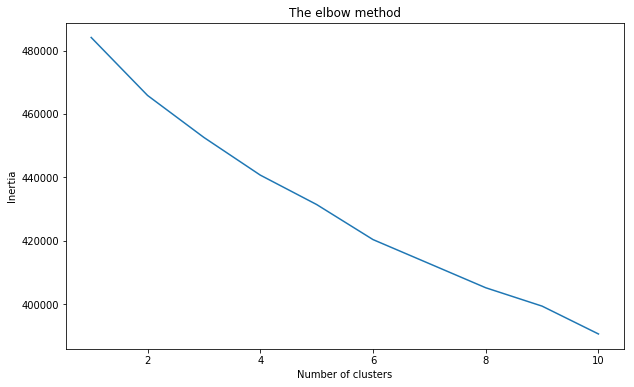

In [53]:
# Using elbow method to determine how many topics to have
plot_inertia(tfidf_train)

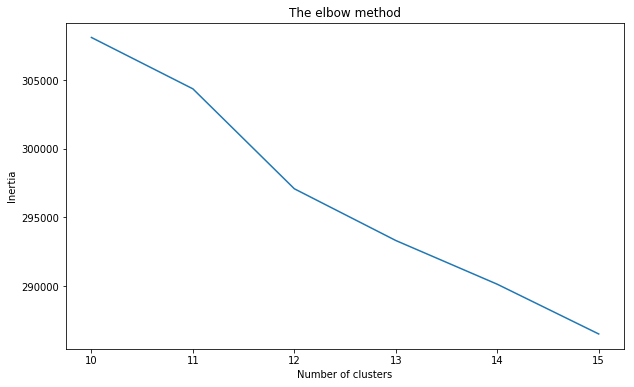

In [86]:
plot_inertia(tfidf_train, start=10, end=15)

In [23]:
# Don't really see any pattern - will go with a middle value
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6)
kmeans.fit(tfidf_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [52]:
topic_labels = pd.concat([pd.Series(kmeans.labels_), X_train.listing_id.reset_index(drop=True), X_train.id.reset_index(drop=True)], axis=1)

In [54]:
topic_labels.columns = ['kmeans_label', 'listing_id', 'id']

In [69]:
topic_labels['comments'] = X_train.comments.reset_index(drop=True)

In [70]:
topic_labels.head()

,kmeans_label,listing_id,id,comments
0,5,4572225,39668754,Allie's apartment was very clean and located i...
1,3,1542279,239649632,"Appartement de 4 chambres Airbnb, avec cuisine..."
2,5,15820512,262350020,Guillermo’s apartment is in a great neighbourh...
3,5,5061165,85828237,Javier and Vicky were very welcoming and accom...
4,2,21214554,347637143,The place was amazing and the location was gre...


In [56]:
topic_labels.kmeans_label.value_counts()

2    413989
5    183479
1    146937
4     70183
3     62920
0     14291
Name: kmeans_label, dtype: int64

In [71]:
topic_labels_test = pd.concat([pd.Series(kmeans.predict(tfidf_test)), X_test.listing_id.reset_index(drop=True), X_test.id.reset_index(drop=True)], axis=1)
topic_labels_test.columns = ['kmeans_label', 'listing_id', 'id']
topic_labels_test['comments'] = X_test.comments.reset_index(drop=True)

In [72]:
topic_labels_test.head()

,kmeans_label,listing_id,id,comments
0,2,4218034,113949495,We loved our stay at the Urban Jungle! The dup...
1,4,20817201,314215888,Is a good place just to sleep and go. Perfect ...
2,2,4152752,185785747,Niko's place is in a centralized area near all...
3,1,20990607,211627258,"Angie is a great host, accommodating, very swe..."
4,2,1759462,66002562,"The place is lovely, and the location is amazi..."


In [63]:
topic_labels_test.kmeans_label.value_counts()

2    103757
5     45943
1     36419
4     17570
3     15678
0      3583
Name: kmeans_label, dtype: int64

Will sample a few reviews and see if the topics make sense.

In [64]:
from random import sample
sample_train = sample(range(X_train.shape[0]), 60)
sample_test = sample(range(X_test.shape[0]), 30)

In [74]:
topic_labels.loc[sample_train].sort_values('kmeans_label')

,kmeans_label,listing_id,id,comments
15909,0,4426877,35444267,The host canceled this reservation 2 days befo...
787634,1,2197401,297255596,"Great place, they were very accommodating."
153334,1,182649,345105753,Great location in the heart of Williamsburg. ...
620250,1,654612,44301099,Kathleen was so accommodating and quick to res...
153402,1,26171844,304954339,"great location, a/c was crucial. communicatio..."
195609,1,11437634,198769425,"Great location near subway, clean apartment an..."
525122,1,27195276,351350781,Very stylish and fun apartment! Madia is a gre...
679742,1,19675743,334903072,"lovely host, friendly, helpful, just a very ni..."
169375,1,8304809,214293652,"Exactly as advertised! Clean, stylish and com..."
156095,1,7983640,341295284,Erica's place is fantastic and a great deal fo...


In [75]:
topic_labels_test.loc[sample_test].sort_values('kmeans_label')

,kmeans_label,listing_id,id,comments
32170,1,7478570,86722635,Great location! Excellent hosts!
86274,1,9783,24941,"he's just great!! very polite, very gentle, ve..."
31625,1,4455094,150372823,"Great place, cozy."
71277,1,21056653,281342900,Great spot
115652,1,23306594,305665377,"Great appartment, very well located, all the a..."
83730,1,10043483,215594176,"We had a great time in this cozy, clean, well-..."
163075,1,1102858,355979746,"Great space, great location. Eric was very com..."
195946,1,9227929,297915139,"Great location, prompt and detailed responses."
46016,2,10413576,322612581,Mahmood was incredibly accommodating. It was a...
185902,2,1728437,33955915,My hosts Cheryl and Caroline were great! Enjoy...


Honestly I think this clustering works because it separates out foreign language reviews (cluster 2) as well as a cluster for negative reviews (cluster 1).  I think this encodes some information and would add to the model.

Will further analyze the clustered topics using wordcloud.

Make output, group by listing_id for further modeling use.

Will give each listing a vector of length 6 for proportion of each topic.

In [79]:
topics = pd.concat([topic_labels, topic_labels_test], axis=0)

In [80]:
topics.kmeans_label.value_counts()

2    517746
5    229422
1    183356
4     87753
3     78598
0     17874
Name: kmeans_label, dtype: int64

In [83]:
topics = pd.get_dummies(topics, columns = ['kmeans_label'], prefix='topic')

In [89]:
def prop(x):
    return sum(x)/len(x)

In [100]:
topics_prop = topics.groupby('listing_id').agg({'topic_0': prop, 'topic_1': prop,'topic_2': prop,'topic_3': prop,'topic_4': prop,'topic_5': prop})

In [101]:
topics_prop.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
listing_id,,,,,,
2454,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2539,0.000000,0.222222,0.777778,0.000000,0.000000,0.000000
2595,0.000000,0.232558,0.302326,0.093023,0.046512,0.325581
3330,0.051282,0.102564,0.435897,0.051282,0.051282,0.307692
3831,0.004329,0.134199,0.571429,0.121212,0.086580,0.082251


In [103]:
topics_prop.to_csv('kmeans_topics.csv', index=True)

DBSCAN kernel died (maybe too many rows) so not gonna use this technique.

In [61]:
# from sklearn.cluster import DBSCAN
# dbsc = DBSCAN(eps = 0.5, min_samples = 1000)
# dbsc.fit(tfidf_train)